In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import ndimage
from skimage import exposure
from tqdm.notebook import tqdm
# This line imports the tqdm library, specifically the notebook version. tqdm is a library for adding progress 
# bars to loops, making it easy to track the progress of operations.
plt.rcParams['figure.figsize'] = [15, 15]
# This line sets the default figure size for Matplotlib plots. In this case, it sets the width and height of the 
# figures to 15 units.

In [2]:
# Read image and convert them to gray!!
def read_image(path):
    img = cv2.imread(path)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_gray, img, img_rgb

left_gray: Grayscale version of the left image 
left_origin: Original BGR version of the left image 
left_rgb: RGB version of the left image 
right_gray: Grayscale version of the right image 
right_origin: Original BGR version of the right image 
right_rgb: RGB version of the right image

In [3]:
left_gray, left_origin, left_rgb = read_image('IMG_5663.jpg')
right_gray, right_origin, right_rgb = read_image('IMG_5664.jpg')

In [4]:
def SIFT(img):
    siftDetector= cv2.xfeatures2d.SIFT_create() # limit 1000 points
    siftDetector= cv2.SIFT_create()  # depends on OpenCV version

    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des

def plot_sift(gray, rgb, kp):
    tmp = rgb.copy()
    img = cv2.drawKeypoints(gray, kp, tmp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

In [5]:
# Better result when using gray images
kp_left, des_left = SIFT(left_gray)
kp_right, des_right = SIFT(right_gray)

[ WARN:0@2.729] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


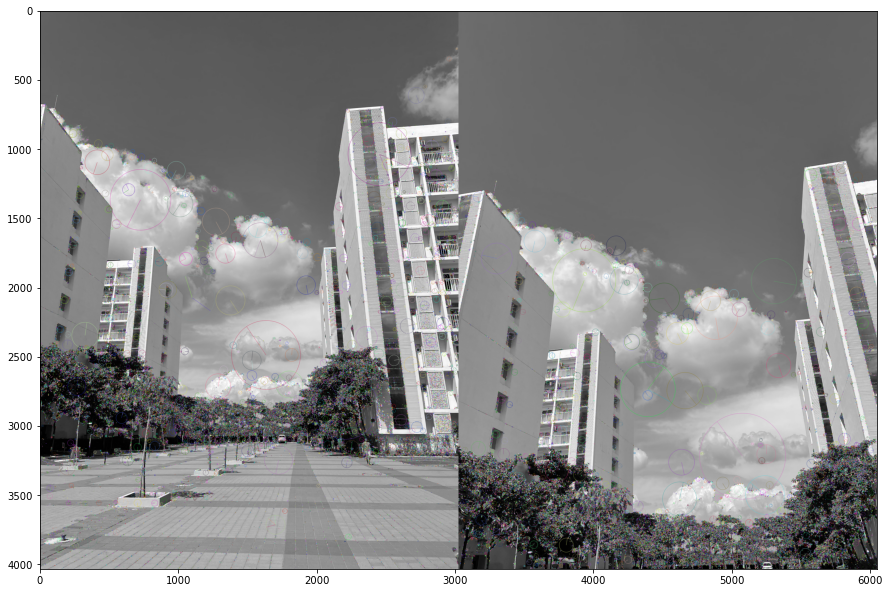

In [6]:
kp_left_img = plot_sift(left_gray, left_rgb, kp_left)
kp_right_img = plot_sift(right_gray, right_rgb, kp_right)
total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)
plt.imshow(total_kp)

In [7]:
def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches

Brute-Force Matcher (cv2.BFMatcher()): 
The Brute-Force Matcher is a simple but computationally expensive method 
for feature matching. For each descriptor in the first set, it computes the distance to all descriptors in 
the second set and returns the closest one. The cv2.BFMatcher() is an implementation of this approach in OpenCV.

Ratio Test:
For each descriptor in the first set (des1), the knnMatch function is used to find the two best matches in 
the second set (des2).The ratio test then checks if the distance of the best match (m.distance) is less than 
a certain threshold times the distance of the second-best match (threshold * n.distance).
If this condition is satisfied, the match is considered good and is added to the good list.

In [8]:
matches = matcher(kp_left, des_left, left_rgb, kp_right, des_right, right_rgb, 0.7)

In [9]:
max_matches_per_keypoint = 2  
filtered_matches = [match for match in matches if len(match) <= max_matches_per_keypoint]

In [10]:
def plot_matches(matches, total_img, color='red', marker='x'):
    match_img = total_img.copy()
    offset = total_img.shape[1] / 2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8'))  # RGB is integer type

    ax.plot(matches[:, 0], matches[:, 1], marker, color=color)
    ax.plot(matches[:, 2] + offset, matches[:, 3], marker, color=color)

    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            color, linewidth=0.06)

    plt.show()

<!-- ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr') -->

These lines plot red 'x' markers at the coordinates of the matched keypoints. The first line plots the left image's keypoints, and the second line plots the right image's keypoints by adding the previously calculated offset to the x-coordinate

<!-- ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5) -->
 
[matches[:, 0], matches[:, 2] + offset]:

matches[:, 0]: This represents the x-coordinates of keypoints in the left image.
matches[:, 2] + offset: This represents the x-coordinates of keypoints in the right image, adjusted by adding the previously calculated offset. The offset is necessary because the right image is concatenated to the right side of the left image.
[matches[:, 1], matches[:, 3]]:

matches[:, 1]: This represents the y-coordinates of keypoints in the left image.
matches[:, 3]: This represents the y-coordinates of keypoints in the right image.
'r':

This specifies the color of the line. Here, it's 'r', which stands for red.
linewidth=0.5:

This sets the width of the line to 0.5, making it relatively thin.
The ax.plot() function is used to draw lines between the keypoints in the left and right images. The first two arguments ([matches[:, 0], matches[:, 2] + offset] and [matches[:, 1], matches[:, 3]]) provide the x and y coordinates for the start and end points of the lines.

So, the line is essentially connecting the matched keypoints from the left and right images with red lines on the plot. The linewidth=0.5 parameter controls the thickness of these lines.

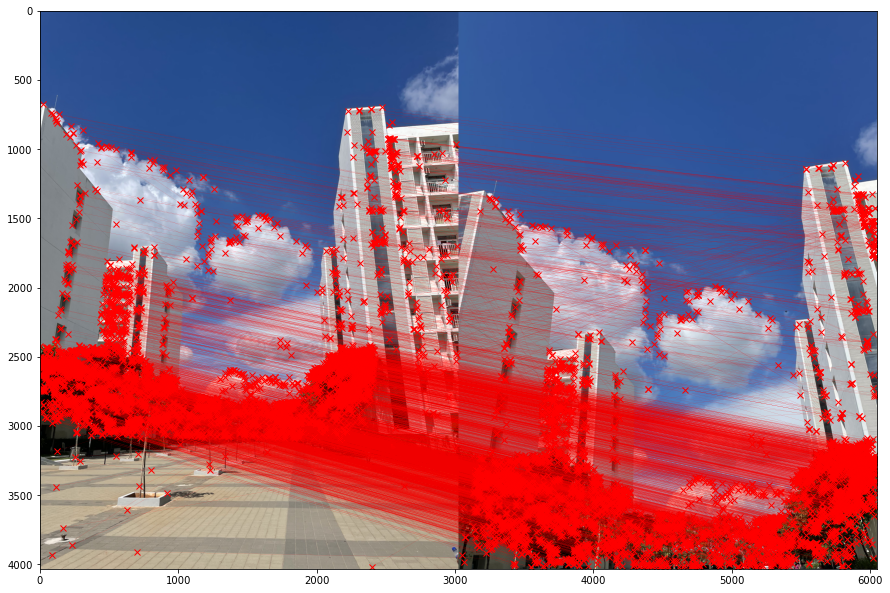

In [11]:
total_img = np.concatenate((left_rgb, right_rgb), axis=1)
plot_matches(matches, total_img) 

In [12]:
def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H

In [13]:
def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx]
    return np.array(point)

The purpose of this function is to randomly sample a subset of matches for further processing, such as estimating a transformation or model based on these points.

In [14]:
def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

In [15]:
def ransac(matches, threshold, iters):
    num_best_inliers = 0
    best_inliers = []
    best_H = np.eye(3)  # Initialize with an identity matrix
    
    for i in range(iters):
        points = random_point(matches)
        H = homography(points)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
            
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

In [16]:
inliers, H = ransac(matches, 0.5, 2000)

inliers/matches: 938/5656


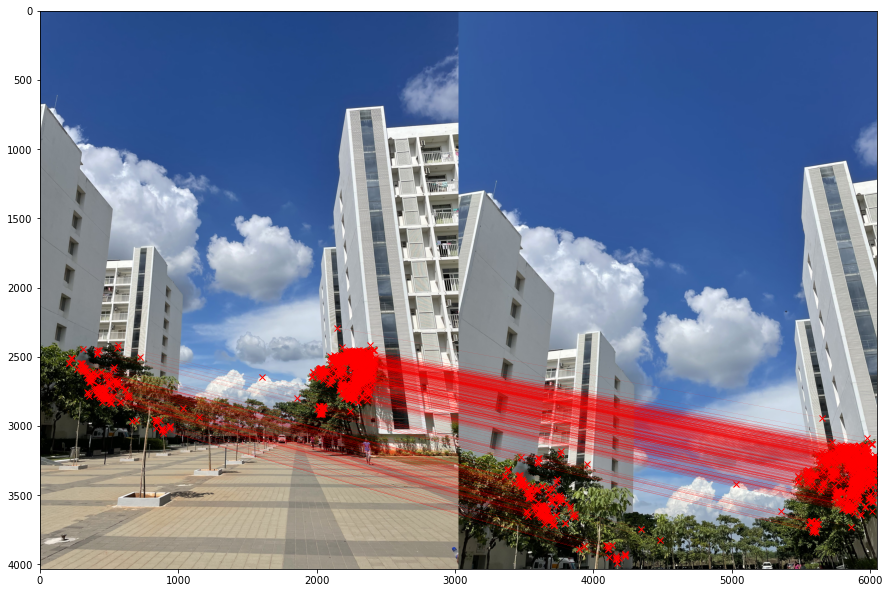

In [17]:
plot_matches(inliers, total_img)

In [18]:
def stitch_img(left, right, H):
    print("Stitching image ...")
    
    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(left.astype('float'), None, 0.1, 1.0, cv2.NORM_MINMAX)   
    right = cv2.normalize(right.astype('float'), None, 0.1, 1.0, cv2.NORM_MINMAX)   
    
    # Warping left image
    height_l, width_l, _ = left.shape
    corners = np.array([[1, 1, 1], [width_l, 1, 1], [width_l, height_l, 1], [1, height_l, 1]])
    corners_new = np.dot(H, corners.T).T
    corners_new /= corners_new[:, 2, None]  # Normalize homogeneous coordinates
    x_news, y_news = corners_new[:, 0], corners_new[:, 1]
    
    x_min, y_min = min(x_news), min(y_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    warped_l = cv2.warpPerspective(src=left, M=H, dsize=size)

    # Warping right image
    height_r, width_r, _ = right.shape
    size = (width_r, height_r)
    warped_r = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)

    # Resize warped_r to match the shape of warped_l
    warped_r = cv2.resize(warped_r, (warped_l.shape[1], warped_l.shape[0]))

    # Find overlapping region
    overlap = np.where(np.all(warped_l != [1, 1, 1], axis=-1) & np.all(warped_r != [1, 1, 1], axis=-1))

    # Extract the arrays from the tuple using indexing
    overlap_rows, overlap_cols = overlap

    # Alpha blending
    alpha = 0.5  # Adjust the blending factor
    stitched_image = np.zeros_like(warped_l)
    stitched_image[overlap_rows, overlap_cols] = alpha * warped_l[overlap_rows, overlap_cols] + (1 - alpha) * warped_r[overlap_rows, overlap_cols]
    stitched_image[~overlap_rows, ~overlap_cols] = warped_l[~overlap_rows, ~overlap_cols]

    return stitched_image

Stitching image ...


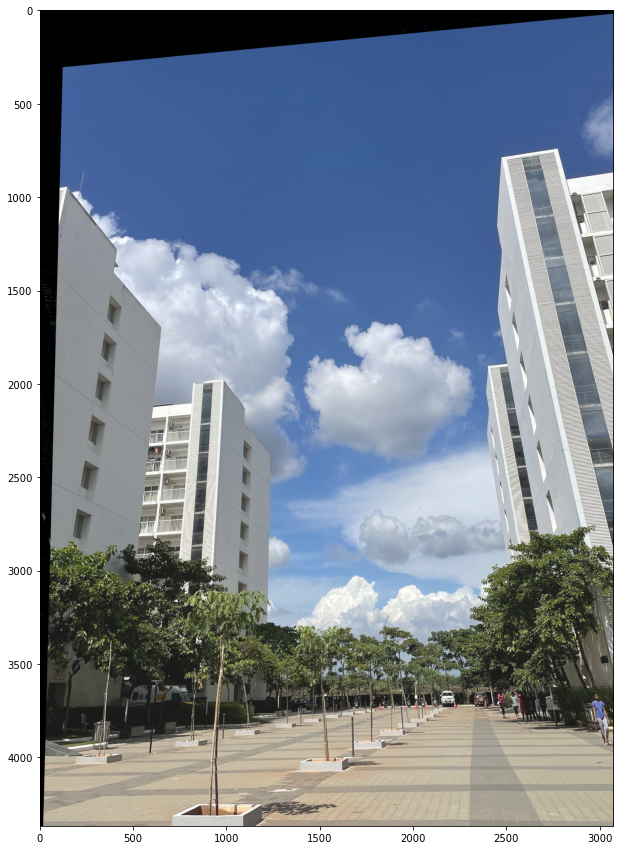

In [19]:
plt.imshow(stitch_img(left_rgb, right_rgb, H))

Stitching image ...
Sharpening image ...


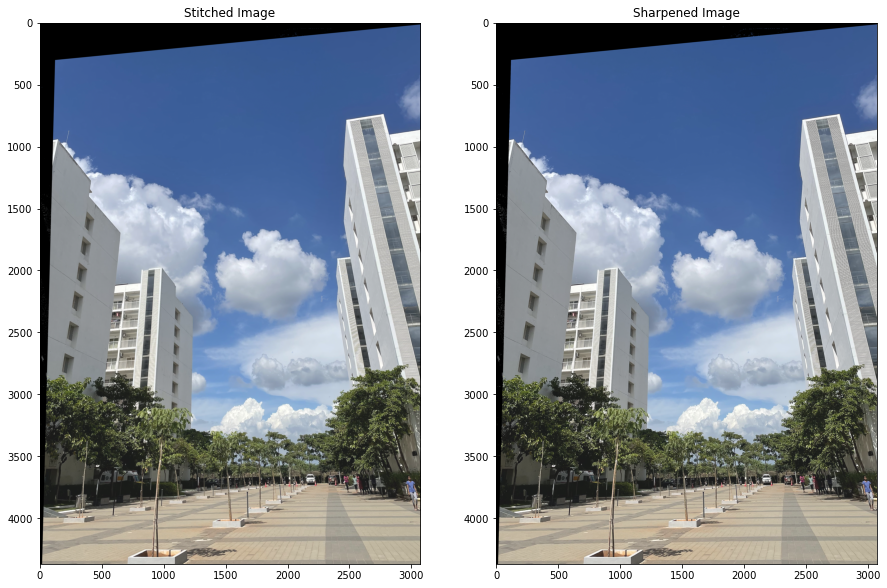

In [20]:
def sharpen_image(image, alpha=1.0):
    print("Sharpening image ...")

    # Define a sharpening filter (Laplacian)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

    # Apply the filter to each color channel separately
    sharpened_channels = [cv2.filter2D(image[:, :, i], -1, kernel) for i in range(3)]

    # Stack the sharpened channels to get the final sharpened image
    sharpened_image = np.stack(sharpened_channels, axis=-1)

    # Clip the values to the valid range [0, 1]
    sharpened_image = np.clip(alpha * sharpened_image + (1 - alpha) * image, 0, 1)

    return sharpened_image

# Assuming 'stitched_image' is the result from the stitching code
stitched_image = stitch_img(left_rgb, right_rgb, H)

# Sharpen the stitched image
alpha_value = 0.7  # Adjust the blending factor
sharpened_stitched_image = sharpen_image(stitched_image, alpha=alpha_value)

# Display the stitched and sharpened image
plt.subplot(1, 2, 1)
plt.title('Stitched Image')
plt.imshow(stitched_image)
plt.axis('on')

plt.subplot(1, 2, 2)
plt.title('Sharpened Image')
plt.imshow(sharpened_stitched_image)
plt.axis('on')

plt.show()


Stitching image ...


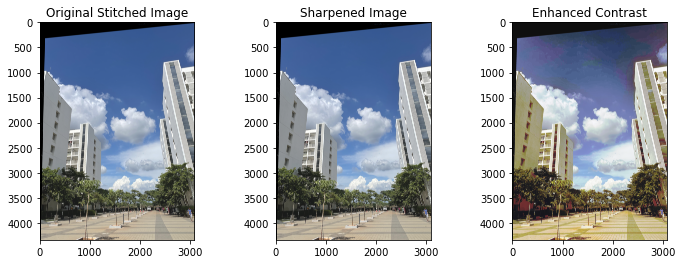

In [155]:
from scipy import ndimage
from skimage import exposure

# Function to apply sharpening filter
def sharpen_image(image, kernel, alpha=1.0):
    # Apply the filter to each color channel separately
    sharpened_channels = [ndimage.convolve(image[:, :, i], kernel, mode='reflect') for i in range(3)]

    # Stack the sharpened channels to get the final sharpened image
    sharpened_image = np.stack(sharpened_channels, axis=-1)

    # Clip the values to the valid range [0, 1]
    sharpened_image = np.clip(alpha * sharpened_image + (1 - alpha) * image, 0, 1)

    return sharpened_image

# Function to apply histogram equalization
def enhance_contrast(image):
    # Apply histogram equalization to each color channel separately
    equalized_channels = [exposure.equalize_hist(image[:, :, i]) for i in range(3)]

    # Stack the equalized channels to get the final equalized image
    equalized_image = np.stack(equalized_channels, axis=-1)

    return equalized_image

# Assuming 'stitched_image' is the result from the stitching code
stitched_image = stitch_img(left_rgb, right_rgb, H)

# Set the sharpening kernel
sharpening_kernel = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])

# Sharpen the stitched image
sharpened_stitched_image = sharpen_image(stitched_image, sharpening_kernel, alpha=0.7)

# Enhance contrast using histogram equalization
equalized_stitched_image = enhance_contrast(sharpened_stitched_image)

# Display the original stitched image, sharpened image, and enhanced image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Original Stitched Image')
plt.imshow(stitched_image)
plt.axis('on')

plt.subplot(1, 3, 2)
plt.title('Sharpened Image')
plt.imshow(sharpened_stitched_image)
plt.axis('on')

plt.subplot(1, 3, 3)
plt.title('Enhanced Contrast')
plt.imshow(equalized_stitched_image)
plt.axis('on')

plt.show()

In [22]:
def compute_accuracy(matches, stitched_image, H):
    # Assuming 'matches' is the list of matches obtained before stitching
    # 'left_rgb' and 'right_rgb' are the original left and right images
    
    # Apply homography to keypoints from the second image
    pts2_transformed = cv2.perspectiveTransform(np.array([matches[:, :2]]).reshape(-1, 1, 2), H)

    # Calculate the Euclidean distances between original and transformed keypoints
    distances_before_stitching = np.linalg.norm(matches[:, 2:] - pts2_transformed[:, 0, :], axis=1)

    # Apply homography to keypoints from the second image after stitching
    pts2_stitched = cv2.perspectiveTransform(np.array([matches[:, :2]]).reshape(-1, 1, 2), np.linalg.inv(H))

    # Calculate the Euclidean distances between original and stitched keypoints
    distances_after_stitching = np.linalg.norm(matches[:, 2:] - pts2_stitched[:, 0, :], axis=1)

    # Calculate the accuracy by comparing the average ratio of distances before and after stitching
    accuracy = np.mean(distances_before_stitching / distances_after_stitching)
    
    return accuracy

# Assuming 'matches' is the list of matches obtained before stitching
# 'stitched_image' is the result from the stitching code
accuracy = compute_accuracy(matches, stitched_image, H)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.0442
